In [3]:
import torch
from torch import nn
from torchviz import make_dot

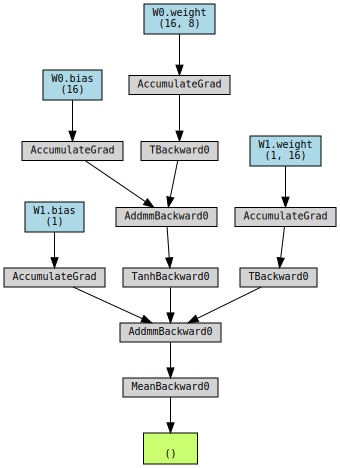

In [5]:
model = nn.Sequential()
model.add_module('W0', nn.Linear(8, 16))
model.add_module('tanh', nn.Tanh())
model.add_module('W1', nn.Linear(16, 1))

x = torch.randn(1, 8)
y = model(x)

make_dot(y.mean(), params=dict(model.named_parameters()))

In [6]:
class LSTMModel(nn.Module):
    """LSTM model for forex prediction."""

    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.0, bidirectional=False):
        """
        Initialize the LSTM model.

        Args:
            input_size (int): Size of input features.
            hidden_size (int): Size of hidden layers.
            num_layers (int): Number of LSTM layers.
            output_size (int): Size of output.
            dropout (float, optional): Dropout probability. Defaults to 0.0.
            bidirectional (bool, optional): Whether to use bidirectional LSTM. Defaults to False.
        """
        super().__init__()
        
        self.model_type = "lstm"
        self.meta_data = {
            "input_size": input_size,
            "hidden_size": hidden_size,
            "num_layers": num_layers,
            "output_size": output_size,
            "dropout": dropout,
            "bidirectional": bidirectional
        }
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

    def forward(self, x):
        """
        Forward pass of the LSTM model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, input_size).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, output_size).
        """
        # LSTM forward pass
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)
        # lstm_out shape: (batch_size, seq_len, hidden_size * num_directions)
        
        # Use the last time step output
        if self.bidirectional:
            lstm_out = lstm_out[:, -1, :]
        else:
            lstm_out = lstm_out[:, -1, :]
        # lstm_out shape: (batch_size, hidden_size * num_directions)
        
        # Apply dropout
        lstm_out = self.dropout(lstm_out)
        
        # Fully connected layer
        out = self.fc(lstm_out)
        # out shape: (batch_size, output_size)
        
        return out


In [26]:
import math
import torch.nn.functional as F

class TransformerModel(nn.Module):
    """Transformer model for forex prediction."""
    
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_heads=8, dropout=0.1):
        """
        Initialize the Transformer model.
        
        Args:
            input_size (int): Size of input features.
            hidden_size (int): Size of hidden layers.
            num_layers (int): Number of transformer layers.
            output_size (int): Size of output.
            num_heads (int, optional): Number of attention heads. Defaults to 8.
            dropout (float, optional): Dropout probability. Defaults to 0.1.
        """
        super().__init__()
        
        self.model_type = "transformer"
        self.meta_data = {
            "input_size": input_size,
            "hidden_size": hidden_size,
            "num_layers": num_layers,
            "output_size": output_size,
            "num_heads": num_heads,
            "dropout": dropout
        }
        
        # Embedding layer to convert input to hidden dimension
        self.embedding = nn.Linear(input_size, hidden_size)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(hidden_size, dropout)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=num_heads,
            dim_feedforward=hidden_size * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        """
        Forward pass of the Transformer model.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, input_size).
            
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, output_size).
        """
        # x shape: (batch_size, seq_len, input_size)
        
        # Apply embedding to convert input to hidden dimension
        x = self.embedding(x)
        # x shape: (batch_size, seq_len, hidden_size)
        
        # Apply positional encoding
        x = self.pos_encoder(x)
        # x shape: (batch_size, seq_len, hidden_size)
        
        # Apply transformer encoder
        transformer_out = self.transformer_encoder(x)
        # transformer_out shape: (batch_size, seq_len, hidden_size)
        
        # Use the last time step output
        transformer_out = transformer_out[:, -1, :]
        # transformer_out shape: (batch_size, hidden_size)
        
        # Apply dropout
        transformer_out = self.dropout(transformer_out)
        
        # Fully connected layer
        out = self.fc(transformer_out)
        # out shape: (batch_size, output_size)
        
        return out


class PositionalEncoding(nn.Module):
    """Positional encoding for Transformer model."""
    
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        """
        Initialize the positional encoding.
        
        Args:
            d_model (int): Hidden dimension.
            dropout (float, optional): Dropout probability. Defaults to 0.1.
            max_len (int, optional): Maximum sequence length. Defaults to 5000.
        """
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Create positional encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        # Register buffer to store positional encoding
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """
        Forward pass of the positional encoding.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, d_model).
            
        Returns:
            torch.Tensor: Output tensor with positional encoding.
        """
        # x shape: (batch_size, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


In [27]:
model = TransformerModel(3, 64, 1, 5, dropout=0.2)

In [30]:
print(model)

TransformerModel(
  (embedding): Linear(in_features=3, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=64, out_features=5, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [34]:
class GRUModel(nn.Module):
    """GRU model for forex prediction."""

    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.0, bidirectional=False):
        """
        Initialize the GRU model.

        Args:
            input_size (int): Size of input features.
            hidden_size (int): Size of hidden layers.
            num_layers (int): Number of GRU layers.
            output_size (int): Size of output.
            dropout (float, optional): Dropout probability. Defaults to 0.0.
            bidirectional (bool, optional): Whether to use bidirectional GRU. Defaults to False.
        """
        super().__init__()
        
        self.model_type = "gru"
        self.meta_data = {
            "input_size": input_size,
            "hidden_size": hidden_size,
            "num_layers": num_layers,
            "output_size": output_size,
            "dropout": dropout,
            "bidirectional": bidirectional
        }
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

    def forward(self, x):
        """
        Forward pass of the GRU model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, input_size).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, output_size).
        """
        # GRU forward pass
        # x shape: (batch_size, seq_len, input_size)
        gru_out, _ = self.gru(x)
        # gru_out shape: (batch_size, seq_len, hidden_size * num_directions)
        
        # Use the last time step output
        gru_out = gru_out[:, -1, :]
        # gru_out shape: (batch_size, hidden_size * num_directions)
        
        # Apply dropout
        gru_out = self.dropout(gru_out)
        
        # Fully connected layer
        out = self.fc(gru_out)
        # out shape: (batch_size, output_size)
        
        return out


In [35]:
model = GRUModel(3, 64, 1, 5, dropout=0.2)

In [36]:
print(model)

GRUModel(
  (gru): GRU(3, 64, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=5, bias=True)
)
